# 時尚服飾圖像辨識

圖像分類被廣泛地應用到很多的領域中，從醫學掃描中危及生命的疾病識別到電視卡通角色的識別。

MNIST數據集（可以說）是最常用的圖像分類入門數據集。它包含手寫數字的28x28灰度圖像，每個灰度圖像都有一個關聯的標籤，用於指示圖像上手寫的數字（0到9之間的整數）。

MNIST在過去幾年中越來越受歡迎, 但也引起了一些問題。

使用MNIST來進行圖像辨識的範例有什麼問題呢？
1. **MNIST太簡單了** - 卷積網絡(Convolution network)可以很容易地在MNIST上達到99.7%的辨識力，即使經典的機械學習(Machine learning)算法也能達到97%。

2. **MNIST被過度使用** - 幾乎每個有深度學習經驗的人都至少遇到過MNIST一次。

3. **NIST無法有效代表現代的電視視覺相關的任務** - Keras的主要貢獻者(François Chollet)也特別提及這一點。

>**François Chollet**
>
>Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no transfer to real CV.
>
> 2:51 AM - Apr 14, 2017


![Fashion-Mnist](https://cdn-images-1.medium.com/max/600/1*GNLB2jtcfb_xTqgQd9ntJA.png)

## 資料集說明

時尚MNIST訓練集是由[Zalando Reserach](https://jobs.zalando.com/tech/)所發佈出來的資料集。它包含60,000個範例圖像，測試集包含10,000個範例圖像。

每個範例圖像都是28x28的灰度圖像（就像原始MNIST中的圖像一樣），與10類（T卹，褲子，套頭衫，連衣裙，大衣，涼鞋，襯衫，運動鞋，包包和踝靴）的標籤相關聯。時尚MNIST也與MNIST具有相同的訓練與測試數據分離結構，以便於學習使用。

相關的詳細資訊說明及資料集下載可以透過Zalando在Github: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist) 來了解更多。

在這篇文章裡頭, 我們會從[Kaggle](https://www.kaggle.com/zalando-research/fashionmnist)上取得這個數據集。

## 資料準備

1. 從[Kaggle](https://www.kaggle.com/zalando-research/fashionmnist/data/)點擊`Download All`下載圖像資料檔"fashionmnist.zip"。
2. 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
3. 解壓縮圖像資料檔到"data"的目錄裡頭。
4. 在"data/"的資料夾會看到兩個檔案
  * `fashion-mnist_test.csv`
  * `fashion-mnist_train.csv`
  
最後你的目錄結構看起來像這樣:

    2.3-fashion-mnist-recognition.ipynb
    data/
    ├── fashion-mnist_test.csv
    └── fashion-mnist_train.csv

## 資料預處理 (Data Preprocessing)
預處理圖片的第一步是調整它們的大小。我們需要有相同大小的所有照片進行訓練。
我會將數據資料轉換型別為`float32`來節省一些記憶的用量並對它們進行歸一化（除以255）。

然後使用one-hot編碼來將10類別的標籤(label)轉換為向量(vector)：

In [1]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 載入資料
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

num_classes = 10 # 標籤總共有10類
img_rows, img_cols, img_channels = 28, 28, 1 # 圖像是 28像素 x 28像素 (灰階: 1)
input_shape = (img_rows, img_cols, img_channels) # (圖像的height, 圖像的width, 圖像的顏色通道數channel)

X = np.array(data_train.iloc[:, 1:]) # Dataframe中 idx(1 ~ 784)的欄都是像素值

# 進行標籤的one-hot編碼
y = to_categorical(np.array(data_train.iloc[:, 0])) # Dataframe 中 idx(0)的欄是標籤

# 把訓練資料進行拆分成訓練(80%)與驗證(20%)資料集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# 測試資料的處理
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

# 對向量進行shape的轉換以符合訓練的input要求
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

# 對每個像素進行型別轉換與歸一化
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_val = X_val.astype('float32')/255

Using TensorFlow backend.


## 網絡模型 (Model)構建

現在我們來定義我們的模型架構。我們將使用具有6個卷積層的前饋(feed-forward)網絡，然後是完全連接的隱藏層。
我們也將在兩者之間使用Dropout層來防止網絡"過擬合(overfitting)"。

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

def create_model_six_conv(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;

在訓練模型之前，我們需要將模型配置為學習算法並進行編譯。我們需要指定: loss: 損失函數，我們要優化。我們不能使用MSE，因為它是不連續的數值。因此，我們使用：categorical_crossentropy optimizer: 我們使用標準隨機梯度下降(Stochastic gradient descent)與涅斯捷羅夫動量(Nesterov momentum) metric: 由於我們正在處理一個分類問題，我們用度量是accuracy。

In [4]:
from keras.optimizers import Adam

batch_size = 256
epochs = 50

#圖像的shape是 (28,28,1)
model = create_model_six_conv((img_rows, img_cols, img_channels)) # 初始化一個模型

# 秀出模型架構
model.summary() 

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

## 訓練 (Training)

現在，我們的模型已經準備好了。在訓練期間，我們的模型將進行迭代批量訓練，每個次的訓練資料的大小為batch_size。對於每批次，模型將會計算出梯度(gradient)，並自動更新網絡的權重。對所有訓練集的一次迭代被稱為一次的循環(epoch)。訓練通常會一直進行到損失收斂於一個常數。

In [5]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 5s 102us/step - loss: 0.8780 - acc: 0.6749 - val_loss: 0.4904 - val_acc: 0.8204
Epoch 2/50
48000/48000 [==============================] - 3s 67us/step - loss: 0.5011 - acc: 0.8215 - val_loss: 0.3820 - val_acc: 0.8568
Epoch 3/50
48000/48000 [==============================] - 3s 67us/step - loss: 0.4042 - acc: 0.8578 - val_loss: 0.3313 - val_acc: 0.8778
Epoch 4/50
48000/48000 [==============================] - 3s 67us/step - loss: 0.3519 - acc: 0.8760 - val_loss: 0.2941 - val_acc: 0.8930
Epoch 5/50
48000/48000 [==============================] - 3s 65us/step - loss: 0.3236 - acc: 0.8857 - val_loss: 0.2961 - val_acc: 0.8952
Epoch 6/50
48000/48000 [==============================] - 3s 65us/step - loss: 0.2950 - acc: 0.8964 - val_loss: 0.2623 - val_acc: 0.8992
Epoch 7/50
48000/48000 [==============================] - 3s 63us/step - loss: 0.2729 - acc: 0.9035 - val_loss: 0.2660 - val_ac

### 訓練過程的可視化

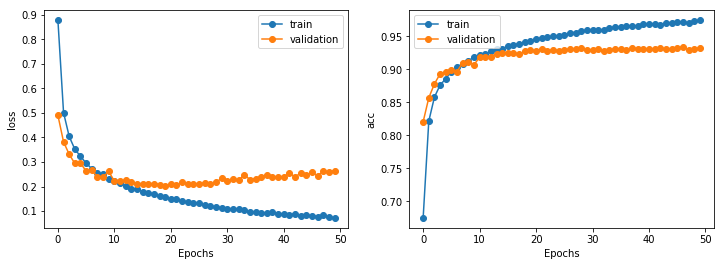

In [6]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()

分析一下訓練過程, 我們可以很明顯看到大約在第10個epochs之後整個模型就開始在驗證資料集有過擬合(overfitting)的現象。
如果要繼續調優的話, 可以朝向增加資料集或進行一些降維的處理。

## 驗證評估 (Evaluation)

In [7]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.250863265352
Test accuracy: 0.9343


### 93.8%的正確率 ~~ 太神奇了, 傑克!!

事實證明，卷積神經網絡分類器比在[這里](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/)報告的最好的分類器(SVM) 89.7%還要更好。

### 每一種類別的預測正確率

In [8]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
y_true = data_test.iloc[:, 0]
corrects = np.nonzero(predicted_classes==y_true)[0]
incorrects = np.nonzero(predicted_classes!=y_true)[0]

10000/10000 [==============================] - 0s 50us/step


In [9]:
from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.88      0.90      0.89      1000
    Class 1       0.99      0.99      0.99      1000
    Class 2       0.91      0.90      0.90      1000
    Class 3       0.92      0.95      0.93      1000
    Class 4       0.91      0.90      0.90      1000
    Class 5       0.99      0.98      0.99      1000
    Class 6       0.83      0.79      0.81      1000
    Class 7       0.96      0.97      0.97      1000
    Class 8       0.99      0.99      0.99      1000
    Class 9       0.96      0.98      0.97      1000

avg / total       0.93      0.93      0.93     10000



顯然，我們的分類器對第6類別的圖像辨識在精度和召回方面的表現相對差。也許我們會在可視化正確和錯誤的預測之後獲得更多的洞察力。

#### 正確辨識的圖像範例:

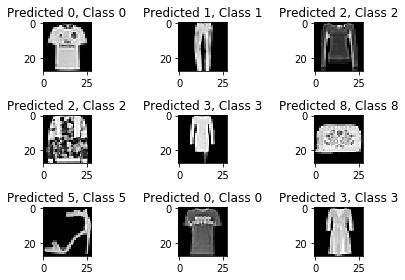

In [10]:
for i, correct in enumerate(corrects[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()
    
plt.show()

#### 辨識錯誤的圖像範例

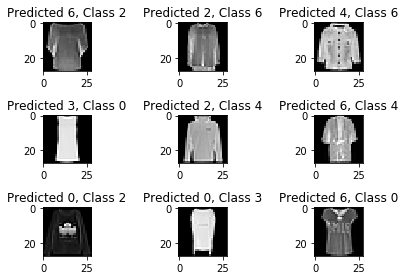

In [12]:
for i, incorrect in enumerate(incorrects[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()
    
plt.show()

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:
* 深度學習也可以很摩登很現代感
* 只要有創造力與天馬行空的想法,很多我們眼睛看到的東西都可以變成應用AI的場景 
* 每個公司都可以擁有自己的訓練圖像資料集
* 電腦宅男也可以跟時尚(fashion)掛上勾了, 下次我們可以說我們是"AI時尚宅男" ...太潮了!!

### 參考:
* [CNN with Keras](https://www.kaggle.com/bugraokcu/cnn-with-keras)
* [zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)
* [Classifying clothes using Tensorflow](https://medium.com/tensorist/classifying-fashion-articles-using-tensorflow-fashion-mnist-f22e8a04728a)
* [Keras官網](http://keras.io/)